<a href="https://colab.research.google.com/github/eakalak-suthampan/102_Flower_Pytorch/blob/master/Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# install pytorch
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# check CUDA version
!nvcc --version

# change cuda version as shown by nvcc 
accelerator = 'cu90' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
!pip install Pillow==4.1.1
import torch
print("Pytorch version: ", torch.__version__)
print("Check GPU available: " ,torch.cuda.is_available())
train_on_gpu = torch.cuda.is_available()
!nvidia-smi



nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148
Pytorch version:  0.4.0
Check GPU available:  True
Sun Jan  6 06:03:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    29W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                

In [2]:
# map my google drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# import all
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import pandas as pd
from os import listdir
import csv

plt.ion()   # interactive mode


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [4]:
!wget "https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip" 
!unzip flower_data.zip

--2019-01-06 06:03:13--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  36.8MB/s    in 9.1s    

2019-01-06 06:03:22 (32.7 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]

Archive:  flower_data.zip
   creating: flower_data/
   creating: flower_data/valid/
   creating: flower_data/valid/61/
  inflating: flower_data/valid/61/image_06296.jpg  
  inflating: flower_data/valid/61/image_06293.jpg  
  inflating: flower_data/valid/61/image_06292.jpg  
  inflating: flower_data/valid/61/image_06261.jpg  
  inflating: flower_data/valid/61/image_06259.jpg  
  inflating: flower_data/valid/61/image_06273.jpg  
   creating: flower_data/valid/95/
 

In [0]:
# TODO: Define your transforms for the training and validation sets
# TODO: Load the datasets with ImageFolder
# TODO: Using the image datasets and the trainforms, define the dataloaders

data_dir = 'flower_data'
my_batch_size = 20
#my_batch_size = 48

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(10),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=my_batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
class_to_idx = image_datasets['train'].class_to_idx


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
#Label mapping
!wget https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
print("Label mapping to class name")
!cat cat_to_name.json

import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

--2019-01-06 06:03:32--  https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json’

cat_to_name.json    100%[===================>]   2.17K  --.-KB/s    in 0s      

2019-01-06 06:03:33 (24.5 MB/s) - ‘cat_to_name.json’ saved [2218/2218]

Label mapping to class name
{"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# for show learning rate during training
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']      

In [0]:
# TODO: Build and train your network
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #best_loss = 10

    for epoch in range(num_epochs):        
      
        # new transform data for every epoch to make sure RandomResizedCrop will not bad crop
        image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=my_batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
        dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))        
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':                                
                scheduler.step()
                print('learning rate = {}'.format(get_lr(optimizer)))
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                if train_on_gpu:
                  inputs = inputs.cuda()
                  labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            #if phase == 'valid':
            #  scheduler.step(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model if epoch valid accuracy better that best accuracy
            if phase == 'valid' and epoch_acc > best_acc:                
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# load pretrained model
model_conv = torchvision.models.densenet201(pretrained=True)

# freeze all pretrained layers
for param in model_conv.parameters():
    param.requires_grad = False

# replace output of classifier layer with number of flower classes (102)
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 102)

# move model to GPU if available
if train_on_gpu:
  model_conv = model_conv.cuda()

model_conv

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [10]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# cosine annealing learning rate scheduler
cosine_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_conv, T_max=25)

# train the model on classifier layer
model_conv = train_model(model_conv, criterion, optimizer_conv, cosine_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
learning rate = 0.01
train Loss: 1.8608 Acc: 0.6090
valid Loss: 0.4138 Acc: 0.9242

Epoch 1/24
----------
learning rate = 0.00996057350657239
train Loss: 0.6256 Acc: 0.8593
valid Loss: 0.2539 Acc: 0.9413

Epoch 2/24
----------
learning rate = 0.009842915805643155
train Loss: 0.4657 Acc: 0.8926
valid Loss: 0.2054 Acc: 0.9523

Epoch 3/24
----------
learning rate = 0.009648882429441256
train Loss: 0.3998 Acc: 0.9074
valid Loss: 0.1902 Acc: 0.9584

Epoch 4/24
----------
learning rate = 0.009381533400219317
train Loss: 0.3286 Acc: 0.9261
valid Loss: 0.1736 Acc: 0.9621

Epoch 5/24
----------
learning rate = 0.009045084971874737
train Loss: 0.3153 Acc: 0.9234
valid Loss: 0.1705 Acc: 0.9597

Epoch 6/24
----------
learning rate = 0.008644843137107058
train Loss: 0.2908 Acc: 0.9313
valid Loss: 0.1726 Acc: 0.9584

Epoch 7/24
----------
learning rate = 0.008187119948743448
train Loss: 0.2537 Acc: 0.9400
valid Loss: 0.1547 Acc: 0.9645

Epoch 8/24
----------
learning rate = 0.0

In [11]:
# unfreezed all pretained layers 
for param in model_conv.parameters():
    param.requires_grad = True
    
# fine tuning by training on all layers
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)    
cosine_alr = lr_scheduler.CosineAnnealingLR(optimizer_conv, T_max=20)
model_conv = train_model(model_conv, criterion, optimizer_conv, cosine_alr, num_epochs=20)

Epoch 0/19
----------
learning rate = 0.001
train Loss: 0.2235 Acc: 0.9425
valid Loss: 0.1123 Acc: 0.9694

Epoch 1/19
----------
learning rate = 0.0009938441702975688
train Loss: 0.1637 Acc: 0.9570
valid Loss: 0.0795 Acc: 0.9768

Epoch 2/19
----------
learning rate = 0.0009755282581475768
train Loss: 0.1345 Acc: 0.9640
valid Loss: 0.0784 Acc: 0.9804

Epoch 3/19
----------
learning rate = 0.0009455032620941839
train Loss: 0.1002 Acc: 0.9750
valid Loss: 0.0710 Acc: 0.9829

Epoch 4/19
----------
learning rate = 0.0009045084971874737
train Loss: 0.0906 Acc: 0.9782
valid Loss: 0.0638 Acc: 0.9866

Epoch 5/19
----------
learning rate = 0.0008535533905932737
train Loss: 0.0961 Acc: 0.9760
valid Loss: 0.0637 Acc: 0.9853

Epoch 6/19
----------
learning rate = 0.0007938926261462366
train Loss: 0.0808 Acc: 0.9789
valid Loss: 0.0633 Acc: 0.9866

Epoch 7/19
----------
learning rate = 0.0007269952498697733
train Loss: 0.0761 Acc: 0.9817
valid Loss: 0.0669 Acc: 0.9866

Epoch 8/19
----------
learning r

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint
model_conv.class_to_idx=image_datasets['train'].class_to_idx 
torch.save(model_conv.state_dict(), 'gdrive/My Drive/pytorch_challenge-master/model_densenet201_tmp.pt')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [13]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
import torchvision
import torch
import torch.nn as nn

# load pretrained model
model_conv = torchvision.models.densenet201(pretrained=True)

# freeze all pretrained layers
for param in model_conv.parameters():
    param.requires_grad = False

# replace output of classifier layer with number of flower classes (102)
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 102)

# load saved model
model_conv.load_state_dict(torch.load('gdrive/My Drive/pytorch_challenge-master/model_densenet201_tmp.pt'))

# move model to cuda if gpu available
if train_on_gpu:
  model_conv = model_conv.cuda()

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


## show valid accuracy for each class

In [0]:
# index to class number
def idx_to_class_number(idx):
  return next(k for k, v in class_to_idx.items() if v == idx)

In [15]:
# track loss and accuracy over 102 flower classes on valid dataset
num_classes = len(cat_to_name)
valid_loss = 0.0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
criterion = nn.CrossEntropyLoss()

model_conv.eval() # eval mode

# iterate over test data
for data, target in dataloaders['valid']:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_conv(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    #for i in range(batch_size):
    for i in range(len(target.cpu().numpy())):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate avg test loss
valid_loss = valid_loss/len(dataloaders['valid'].dataset)
print('Test Loss: {:.6f}\n'.format(valid_loss))

for i in range(num_classes):
    class_name = cat_to_name[idx_to_class_number(i)] # get class name
    if class_total[i] > 0:        
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            class_name, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_name))

print('\nTest Accuracy (Overall): %2g%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))        

Test Loss: 0.051460

Test Accuracy of pink primrose: 100% ( 8/ 8)
Test Accuracy of globe thistle: 100% ( 4/ 4)
Test Accuracy of blanket flower: 100% ( 6/ 6)
Test Accuracy of trumpet creeper: 100% ( 5/ 5)
Test Accuracy of blackberry lily: 100% ( 6/ 6)
Test Accuracy of snapdragon: 100% (10/10)
Test Accuracy of colt's foot: 100% ( 5/ 5)
Test Accuracy of king protea: 100% ( 5/ 5)
Test Accuracy of spear thistle: 100% ( 1/ 1)
Test Accuracy of yellow iris: 100% ( 7/ 7)
Test Accuracy of globe-flower: 100% ( 2/ 2)
Test Accuracy of purple coneflower: 100% (16/16)
Test Accuracy of peruvian lily: 100% (11/11)
Test Accuracy of balloon flower: 100% ( 4/ 4)
Test Accuracy of hard-leaved pocket orchid: 100% ( 6/ 6)
Test Accuracy of giant white arum lily: 100% ( 7/ 7)
Test Accuracy of fire lily: 100% ( 4/ 4)
Test Accuracy of pincushion flower: 100% ( 8/ 8)
Test Accuracy of fritillary: 100% (12/12)
Test Accuracy of red ginger: 100% ( 5/ 5)
Test Accuracy of grape hyacinth: 100% ( 2/ 2)
Test Accuracy of co

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
# TODO: Process a PIL image for use in a PyTorch model
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    data_transforms = transforms.Compose([
                         transforms.Resize(256),
                         transforms.CenterCrop(224),
                         transforms.ToTensor(),
                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image)
    return data_transforms(image)           

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

Text(0.5,1,'stemless gentian')

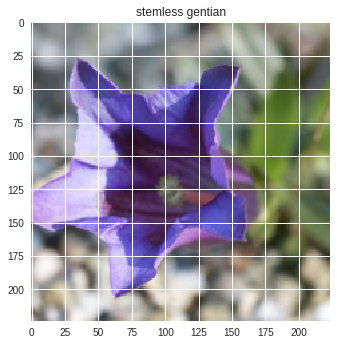

In [23]:
img = 'flower_data/valid/28/image_05267.jpg'
img2 = 'flower_data/valid/69/image_05993.jpg'
img3 = 'flower_data/valid/61/image_06261.jpg'
img4 = 'flower_data/valid/33/image_06444.jpg'
image_tensor = process_image(img)
image_class_name = cat_to_name['28']
ax = imshow(image_tensor)
ax.set_title(image_class_name)


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model_conv, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    
    # preprocessing image
    image_tensor = process_image(image_path)
    image_tensor = image_tensor.unsqueeze(0) # add batch dim
    
    # move image tensor to cuda if available
    train_on_gpu = torch.cuda.is_available()
    model_conv.eval() # eval mode    
    if train_on_gpu:
        image_tensor = image_tensor.cuda()

    # feed forward image tensor        
    output = model_conv(image_tensor)
    
    # softmax output to probability
    sm = torch.nn.Softmax(dim=1)
    
    # return only topk
    probs, classes = sm(output).topk(topk) 
    
    # convert probs and classes to numpy 1D and return
    return probs.detach().cpu().numpy().reshape(-1), classes.detach().cpu().numpy().reshape(-1)
        

In [20]:
# demo predict function
probs, classes = predict(img, model_conv, topk=5)
class_names = [cat_to_name[idx_to_class_number(i)] for i in classes]
path_numbers = [idx_to_class_number(i) for i in classes]
print("input: ", img)
print("top 5 predicted classes (path number)", path_numbers)
print("classes name", class_names)
print("probability for each class", probs)


input:  flower_data/valid/28/image_05267.jpg
top 5 predicted classes (path number) ['28', '55', '84', '40', '95']
classes name ['stemless gentian', 'pelargonium', 'columbine', 'lenten rose', 'bougainvillea']
probability for each class [0.98119605 0.01219783 0.00167657 0.0013979  0.00104584]


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
def sanity_check(img, model_conv):
  probs, classes = predict(img, model_conv, topk=5)
  classes_name = [cat_to_name[idx_to_class_number(i)] for i in classes]
  image_tensor = process_image(img)
  ax = imshow(image_tensor)
  ax.set_title(classes_name[0])
  df = pd.DataFrame({'class':classes_name, 'prob':probs})
  ax = df.plot.barh(x='class', y='prob')  

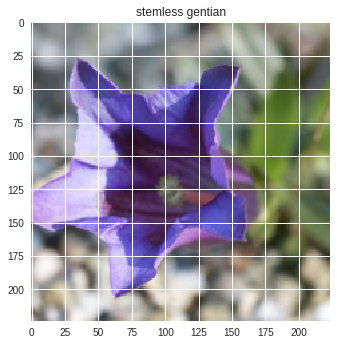

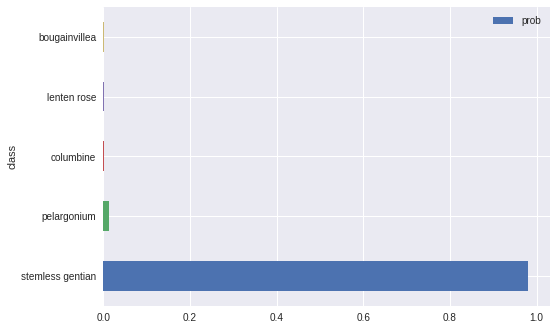

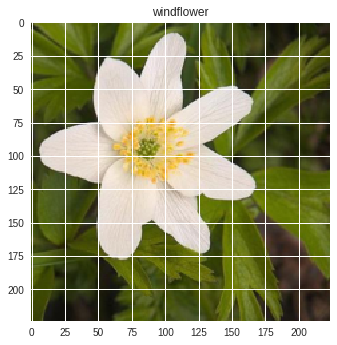

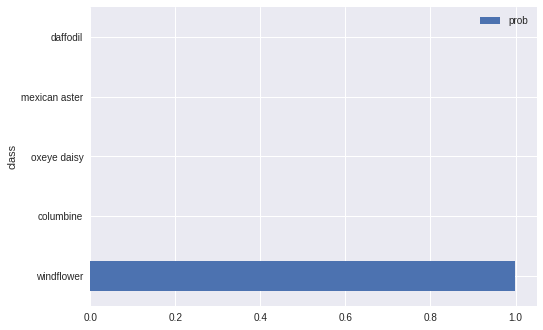

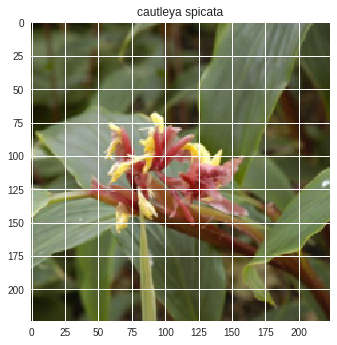

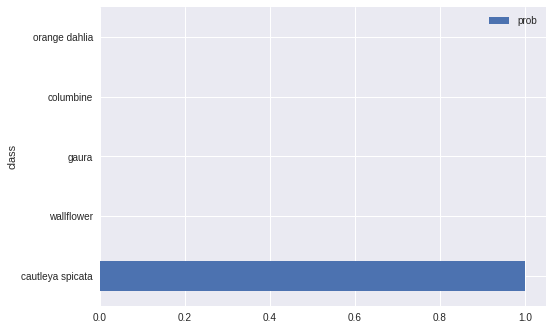

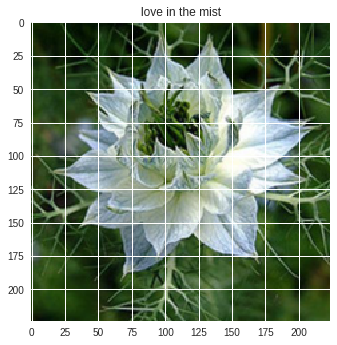

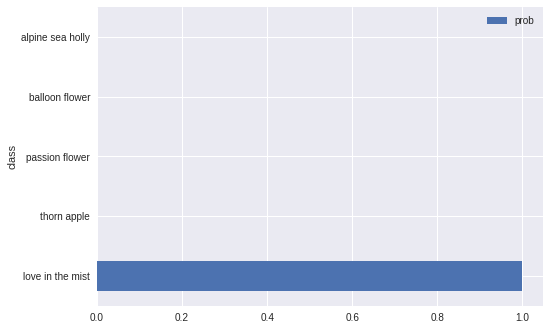

In [22]:
# TODO: Display an image along with the top 5 classes
sanity_check(img, model_conv)
sanity_check(img2, model_conv)
sanity_check(img3, model_conv)
sanity_check(img4, model_conv)

## Submit test predictions to Kaggle 

In [0]:
# download test data from kaggle
# https://www.kaggle.com/c/oxford-102-flower-pytorch/data
!pip install kaggle
!cd 
!cp 'gdrive/My Drive/kaggle.json' /root/.kaggle/ 
!rm -rf flower_data*
!rm -rf sample_submission.csv
!kaggle competitions download -c oxford-102-flower-pytorch
!unzip flower_data.zip

  0% 0.00/15.2k [00:00<?, ?B/s]
100% 15.2k/15.2k [00:00<00:00, 14.2MB/s]
 98% 323M/330M [00:12<00:00, 37.0MB/s]
100% 330M/330M [00:12<00:00, 28.3MB/s]
Archive:  flower_data.zip
  inflating: flower_data/cat_to_name.json  
   creating: flower_data/test/
  inflating: flower_data/test/image_00005.jpg  
  inflating: flower_data/test/image_00006.jpg  
  inflating: flower_data/test/image_00024.jpg  
  inflating: flower_data/test/image_00025.jpg  
  inflating: flower_data/test/image_00029.jpg  
  inflating: flower_data/test/image_00050.jpg  
  inflating: flower_data/test/image_00060.jpg  
  inflating: flower_data/test/image_00065.jpg  
  inflating: flower_data/test/image_00092.jpg  
  inflating: flower_data/test/image_00099.jpg  
  inflating: flower_data/test/image_00114.jpg  
  inflating: flower_data/test/image_00116.jpg  
  inflating: flower_data/test/image_00132.jpg  
  inflating: flower_data/test/image_00176.jpg  
  inflating: flower_data/test/image_00177.jpg  
  inflating: flower_data/tes

In [0]:
# make prediction on test data
test_path = "flower_data/test"
test_files = listdir(test_path)
test_result_list = []

print("Testing...")

for test_file in test_files:
    image_path = test_path + "/" + test_file
    _, class_idx = predict(image_path, model_conv, topk=1)    
    test_result_list.append((test_file, idx_to_class_number(class_idx)))

print("done.")
print()

Testing...
done.



In [0]:
# write predicted results to csv
import csv
!rm -rf submission.csv
with open('submission.csv', mode='w') as submission_file:
    submission_writer = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    submission_writer.writerow(("file_name", "id"))
    for row in test_result_list:
        submission_writer.writerow(row)

!head submission.csv        

file_name,id
image_01071.jpg,46
image_01474.jpg,51
image_06805.jpg,21
image_00006.jpg,77
image_01996.jpg,80
image_05799.jpg,38
image_07327.jpg,94
image_05678.jpg,4
image_04292.jpg,18


In [0]:
#!kaggle competitions submit oxford-102-flower-pytorch -f "submission.csv" -m "2nd model_densenet201_9927.pt"

100% 16.0k/16.0k [00:01<00:00, 9.51kB/s]
Successfully submitted to Oxford 102 Flower Pytorch